In [25]:
import time
import requests
import numpy as np
import pandas as pd
import yfinance as yf
from talib import abstract
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import datetime
import mplfinance as mpf
import pandas_datareader as data

In [26]:
# # DataFrame Setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
pd.set_option('display.width', 5000)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# # Global Variables Setting
symbol = 'BTCUSDT'
url = 'https://api.binance.com/'

# # Get Market Data
def GetKline(url, symbol, interval, startTime = None, endTime = None):
    try:
        data = requests.get(url + 'api/v3/klines', params={'symbol': symbol, 'interval': interval, 'startTime': startTime, 'limit': 1000}).json()
    except Exception as e:
        print ('Error! problem is {}'.format(e.args[0]))
    tmp  = []
    pair = []
    for base in data:
        tmp  = []
        for i in range(0,6):
            if i == 0:
                base[i] = datetime.fromtimestamp(base[i]/1000)
            tmp.append(base[i])
        pair.append(tmp)
    df = pd.DataFrame(pair, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    df = df.astype(float)
    return df

def GetHistoricalKline(url, symbol, interval, startTime):
    # init
    klines = GetKline(url, symbol, interval)
    tmptime = ToMs(klines.iloc[0].name)
    
    # Send request until tmptime > startTime
    while tmptime > startTime:
        tmptime -= PeriodToMs(interval) * 1000 # tmp minus period ms plus 1000 (1000 K)
        if tmptime < startTime:
            tmptime = startTime
        tmpdata = GetKline(url, symbol, interval, tmptime)
        klines  = pd.concat([tmpdata, klines])

    return klines.drop_duplicates(keep='first', inplace=False)

# Math Tools
def ToMs(date):
    return int(time.mktime(time.strptime(str(date), "%Y-%m-%d %H:%M:%S")) * 1000) # Binance timestamp format is 13 digits

def PeriodToMs(period):
    Ms = None
    ToSeconds = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }
    unit = period[-1]

    if unit in ToSeconds:
        try:
            Ms = int(period[:-1]) * ToSeconds[unit] * 1000
        except ValueError:
            pass
    return Ms



if __name__ == "__main__":
    klines = GetKline(url, symbol, '1d', ToMs('2021-01-01 08:00:00'))

In [27]:
def RSI(df, period):
    return abstract.RSI(df, timeperiod=period)

In [28]:
stock_num = "BTC-USD"
stock = yf.Ticker(stock_num)
startDate = "2021-01-01"
stock_df = pd.DataFrame(stock.history(start=startDate))
stock_df = stock_df.reset_index()
stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
stock_df['DIF'] = stock_df['EMA_12'] - stock_df['EMA_26']
stock_df['MACD'] = stock_df['DIF'].ewm(span=9, adjust=False).mean()
stock_df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_12,EMA_26,DIF,MACD
91,2021-04-01,58926.562500,59586.070312,58505.277344,59095.808594,61669163792,0,0,57018.993197,55512.501770,1506.491426,1462.661902
92,2021-04-02,59098.878906,60267.187500,58869.281250,59384.312500,58727860620,0,0,57382.888474,55799.302565,1583.585909,1486.846704
93,2021-04-03,59397.410156,60110.269531,57603.890625,57603.890625,59641344484,0,0,57416.888805,55932.975755,1483.913050,1486.259973
94,2021-04-04,57604.839844,58913.746094,57168.675781,58758.554688,50749662970,0,0,57623.298941,56142.277898,1481.021043,1485.212187
95,2021-04-06,59344.281250,59475.406250,59003.703125,59049.828125,61942726656,0,0,57842.764969,56357.651989,1485.112980,1485.192346


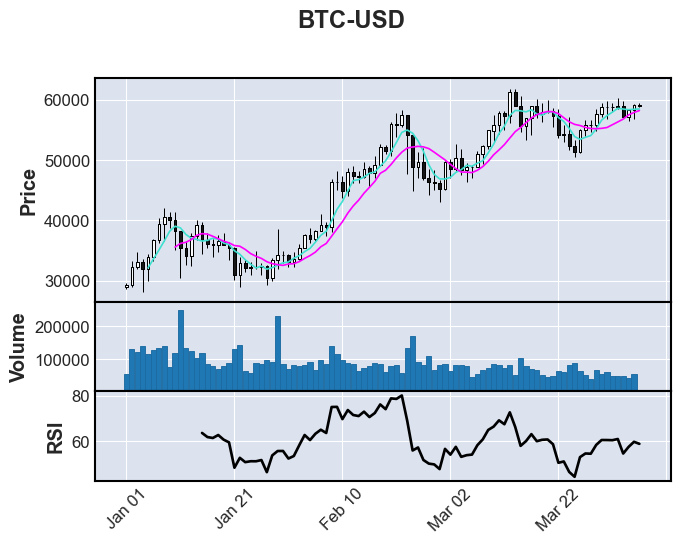

In [29]:
index  = mpf.make_addplot(RSI(klines, 14), panel = 2, ylabel = 'RSI', color = 'black')
mpf.plot(klines, type = 'candle', mav=(5,10),title = 'BTC-USD',addplot = [index],volume = True)

[*********************100%***********************]  1 of 1 completed


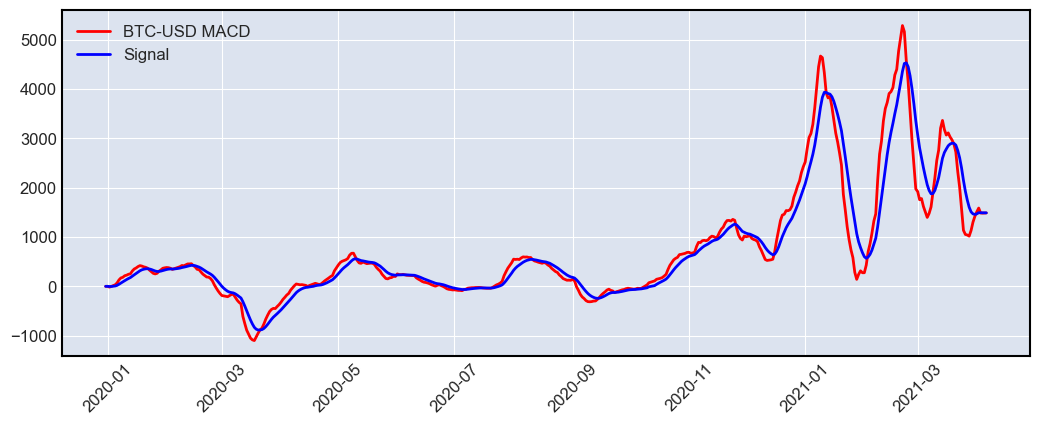

In [30]:
df=yf.download('BTC-USD',start="2020-01-01")
#Calculate the MACD and Signal line indicators
#Calculate the short term exponential moving average (EMA)
#指數移動平均線
ShortEMA=df.Close.ewm(span=12,adjust=False).mean()
#Calculate the long term exponential moving average (EMA)
LongEMA=df.Close.ewm(span=26,adjust=False).mean()
#Calculat the MACD line
MACD=ShortEMA-LongEMA
#Calculat the Signal line
signal=MACD.ewm(span=9,adjust=False).mean()
plt.figure(figsize=(12.5,4.5))
plt.xticks(rotation=45)
plt.plot(df.index,MACD,label='BTC-USD MACD',color='red')
plt.plot(df.index,signal,label='Signal',color='Blue')
plt.legend(loc='upper left')
plt.show()

In [31]:
df['MACD']=MACD
df['Signal Line']=signal
df.tail()

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line
Date,,,,,,,,
2021-04-01,58926.562500,59586.070312,58505.277344,59095.808594,59095.808594,61669163792,1511.502459,1470.029382
2021-04-02,59098.878906,60267.187500,58869.281250,59384.312500,59384.312500,58727860620,1588.225816,1493.668668
2021-04-03,59397.410156,60110.269531,57603.890625,57603.890625,57603.890625,59641344484,1488.209312,1492.576797
2021-04-04,57604.839844,58913.746094,57168.675781,58758.554688,58758.554688,50749662970,1484.999108,1491.061259
2021-04-06,59344.281250,59475.406250,59003.703125,59049.828125,59049.828125,61942726656,1488.796411,1490.608290


In [32]:
def Buy_Sell(signal):
  Buy=[]
  Sell=[]
  flag=-1

  for i in range(0,len(signal)):
    if signal['MACD'][i] > signal['Signal Line'][i]:
      Sell.append(np.nan)
      if flag !=1:
        Buy.append(signal['Close'][i])
        flag=1
      else:
        Buy.append(np.nan)
    elif signal['MACD'][i] < signal['Signal Line'][i]:
      Buy.append(np.nan)
      if flag !=0:
        Sell.append(signal['Close'][i])
        flag=0
      else:
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)
 
  return(Buy,Sell)

In [36]:
a=Buy_Sell(df)
df['Buy_Signal_Price']=a[0]
df['Sell_Signal_Price']=a[1]
df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,
2021-03-22,57517.890625,58471.480469,54288.156250,54529.144531,54529.144531,56521454974,2328.835841,2757.881581,NaN,NaN
2021-03-23,54511.660156,55985.441406,53470.695312,54738.945312,54738.945312,56435023914,2008.500379,2608.005341,NaN,NaN
2021-03-24,54710.488281,57262.382812,52514.332031,52774.265625,52774.265625,70567223787,1577.909824,2401.986238,NaN,NaN
2021-03-25,52726.746094,53392.386719,50856.570312,51704.160156,51704.160156,67999812841,1137.206135,2149.030217,NaN,NaN
2021-03-26,51683.011719,55137.312500,51579.855469,55137.312500,55137.312500,56652197978,1052.835555,1929.791285,NaN,NaN
2021-03-27,55137.566406,56568.214844,54242.910156,55973.511719,55973.511719,47266542233,1041.440473,1752.121122,NaN,NaN
2021-03-28,55974.941406,56610.312500,55071.113281,55950.746094,55950.746094,47686580918,1018.828374,1605.462573,NaN,NaN
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57750.199219,57625587027,1133.047881,1510.979634,NaN,NaN
2021-03-30,57750.132812,59447.222656,57251.550781,58917.691406,58917.691406,54414116432,1302.757151,1469.335138,NaN,NaN


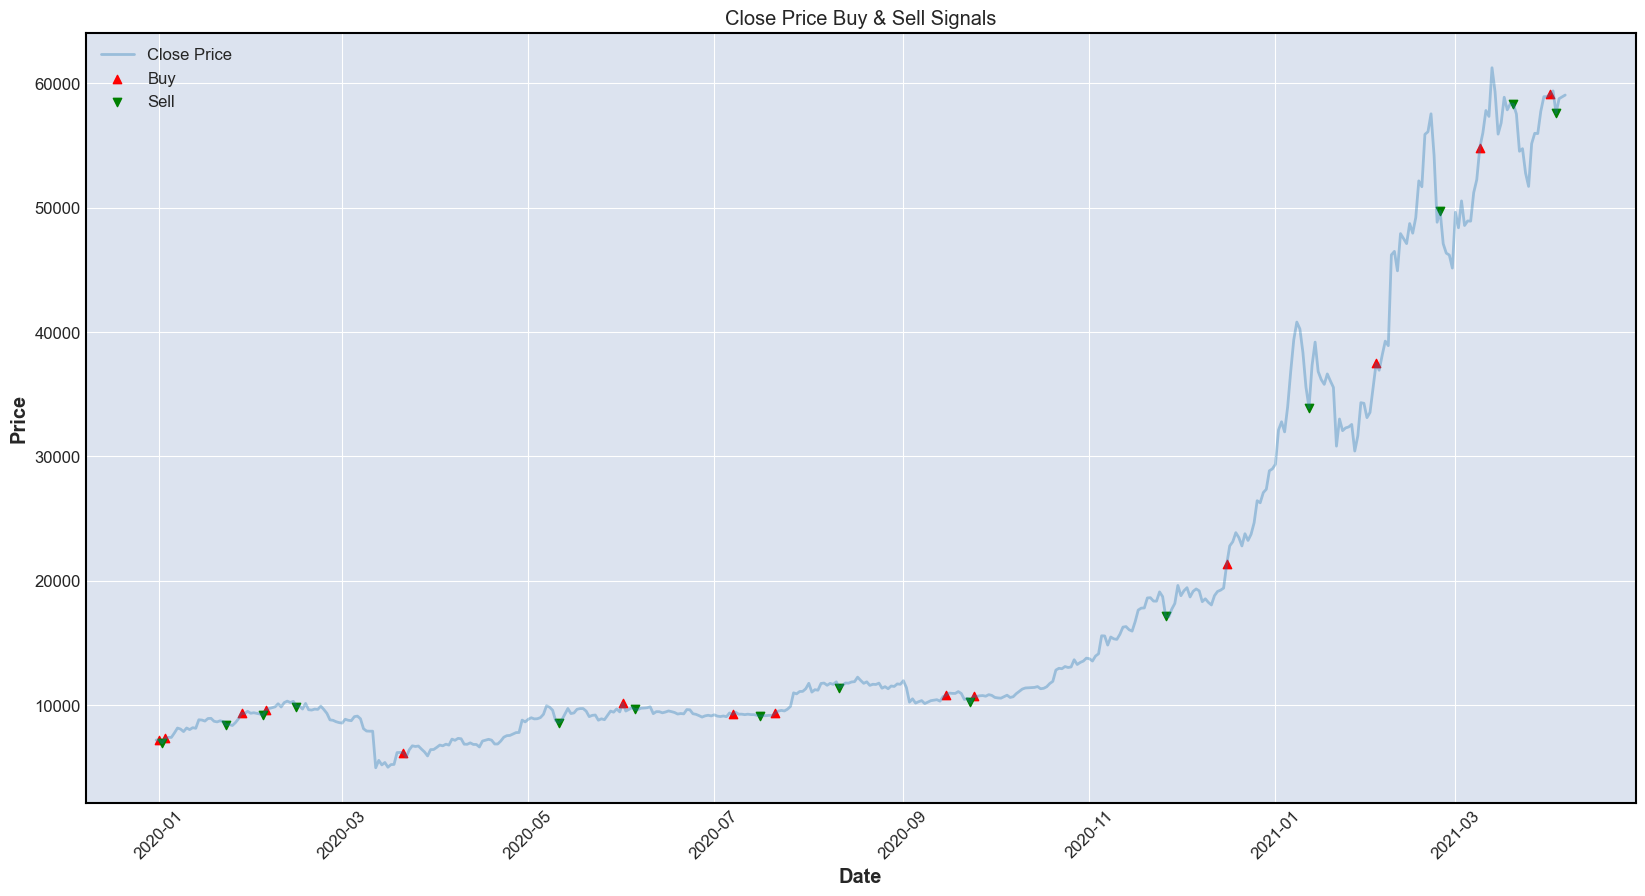

In [41]:
plt.figure(figsize=(20,10))
plt.scatter(df.index,df['Buy_Signal_Price'],color='red', label='Buy',marker='^',alpha=1)
plt.scatter(df.index,df['Sell_Signal_Price'],color='green', label='Sell',marker='v',alpha=1)
plt.plot(df['Close'], label='Close Price', alpha=0.35)
plt.title('Close Price Buy & Sell Signals')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()